In [108]:
import os, sys 
import pandas as pd
import pickle as pk
from pathlib2 import Path
from evaluate import autoGrader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#import dataframe as df
#pip install pathlib2

fd = Path(os.getcwd())
fd_data = fd/'data'

### get the data

In [109]:
# load training data
d_train = pd.read_csv(fd_data/'training_data.csv',parse_dates = ['t_ob'])  #parse_dates: parse as date，自动改为时间，不需要再用pd.to_datetime转换
# load features for closed test data
X_ind_test = pd.read_csv(fd_data/'closed_test_X.csv', parse_dates = ['t_ob'])

In [110]:
from datetime import datetime, date
time_original = '2020-03-01 00:00:00'
time_original_1 = datetime.strptime(time_original,"%Y-%m-%d %H:%M:%S")
d_train['time'] = d_train['t_ob']-time_original_1 
d_train['duration']=d_train['time'].astype('timedelta64[s]')/60

X_ind_test['time'] = X_ind_test['t_ob']-time_original_1
X_ind_test['duration']=X_ind_test['time'].astype('timedelta64[s]')/60

In [2]:
# 不考虑时间，把每个时刻的数据作为一组(x,y)，直接去掉t_ob这一列
#d_train=d_train.drop('t_ob',axis=1)
#X_ind_test=X_ind_test.drop('t_ob',axis=1)

### train_test split

In [111]:
# create X and Y and run the basic regression model
y = d_train['PM2.5']  # y:PM2.5 
X= d_train.drop(['PM2.5','t_ob','time'], axis=1)  #x:other variable

# split the dataset in training set and test set
from sklearn.model_selection import train_test_split
# training set 80%, testing set 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 

### data standardization

In [112]:
X_train.head(2)

,风向,PM10,室内温度,室内湿度,SO2,O3,NOx,NO2,NO,CO,气压,大气湿度,大气温度,风速,duration
3283,66.666667,35.483333,27.918333,19.231667,6.698333,78.585000,38.89,37.710,0.768333,0.486667,1016.316667,36.950000,15.316667,3.483333,32890.0
4126,17.166667,38.950000,24.685000,32.845000,4.456667,40.253333,48.55,40.535,5.228333,0.978333,1017.066667,92.583333,9.150000,1.400000,42410.0


In [113]:
X_train.columns

Index(['风向', 'PM10', '室内温度', '室内湿度', 'SO2', 'O3', 'NOx', 'NO2', 'NO', 'CO',
       '气压', '大气湿度', '大气温度', '风速', 'duration'],
      dtype='object')

In [114]:
# 计算均值和方差，用于之后的标准化
training_mean = np.mean(X_train,axis=0)
training_std=np.std(X_train,axis=0)

In [115]:
data_columns=['风向', 'PM10', '室内温度', '室内湿度', 'SO2', 'O3', 'NOx', 'NO2', 'NO',
       'CO', '气压', '大气湿度', '大气温度', '风速', 'duration']
# 标准化training data
for i in data_columns:
    X_train[i]=(X_train[i]-training_mean[i])/training_std[i]
# 标准化test data
for i in data_columns:
    X_test[i]=(X_test[i]-training_mean[i])/training_std[i]

<ipython-input-115-e6fe28e2c03e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[i]=(X_train[i]-training_mean[i])/training_std[i]
<ipython-input-115-e6fe28e2c03e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[i]=(X_test[i]-training_mean[i])/training_std[i]


### knn

In [116]:
# 1. import the model
from sklearn.neighbors import KNeighborsRegressor

# 2. initialize the model
# n_neighbors: hyperparameter k
knn = KNeighborsRegressor(n_neighbors=10)

# 3. fit the model to the training set
knn_model=knn.fit(X_train,y_train)

In [117]:
# 4. evaluate the model performance
knn.score(X_train,y_train)

0.9849304031106163

In [26]:
predictions=knn.predict(X_train)
predicted = pd.DataFrame(list(predictions))

In [27]:
predicted

,0
0,14.010000
1,29.531667
2,62.775000
3,31.483333
4,18.070000
...,...
9144,38.215000
9145,46.451667
9146,62.160000
9147,23.168333


### choose the optimal k

In [48]:
import time
from sklearn import model_selection
start_cv=time.time()
# values of k
parameters = {'n_neighbors':[i for i in range(1,30)]}

# initialize the knn model
knn = KNeighborsRegressor()

# Exhaustive search over specified parameter values for an estimator
clf = model_selection.GridSearchCV(knn, parameters)

# fit the model on the training set
clf.fit(X_train, y_train)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)
end_cv=time.time()

The best parameter value is: 
{'n_neighbors': 2}
The best score is: 
0.9933128195390057


In [118]:
# get the final model
knn_final = KNeighborsRegressor(n_neighbors = clf.best_params_['n_neighbors']) #把通过上面测试得到的最优值

In [120]:
# train the final model
knn_final.fit(X_train, y_train)
knn_final.score(X_train,y_train)

0.9984979442621738

In [121]:
# evaluate the model using test dataset
knn_final.score(X_test,y_test)

0.996615948700408

### use the final model for prediction

In [122]:
# x for prediction
# training set和test set是标准化过的，用到新的数据集上怎么处理
x_for_prediction=X_ind_test.drop(['t_ob','time'], axis=1) 
#x_for_prediction=X_ind_test.drop(['t_ob','time'], axis=1) 
x_for_prediction.head(1)

,风向,PM10,室内温度,室内湿度,SO2,O3,NOx,NO2,NO,CO,气压,大气湿度,大气温度,风速,duration
0,129.5,50.266667,26.851667,52.27,5.965,180.263333,7.696667,6.688333,0.656667,0.653333,1006.8,76.333333,24.916667,1.483333,132480.0


In [123]:
# 对其进行标准化处理
for i in data_columns:
    x_for_prediction[i]=(x_for_prediction[i]-training_mean[i])/training_std[i]

In [124]:
X_ind_test['prediction'] = knn_final.predict(x_for_prediction)

In [125]:
result=X_ind_test[['t_ob','prediction']] #提取出需要的列
result = result.rename(columns={ 'prediction': 'PM2.5'})  #修改列名
result.to_csv('submission_knn.csv',index=False)  #保存文件

In [126]:
autoGrader(fd/'submission_knn.csv')

[Enter] to confirm your submission file is placed at D:\code_own\CodingTest-SunyuWang\to_players\submission_knn.csv)

Submission time: 2022-06-17 17:49:25.157007
 - RMSE: 10.325
 - R sq.: 0.278
 - Max. abs. residual: 32.450
 - Min. abs. residual: 0.008
 - Logging results. [Enter] to make sure 'submission_history.csv' is closed: 
 - Notes for this submission: 
 ! Results logged in 'submission_history.csv'.
 ! Submission file saved to '/old_submissions/submission_2022_06_17_17_49_25.csv'.
Evaluation Successful. Press to quit...


结果并不是很理想，虽然是用grid search找到的最优k，在test dataset上表现也不错，但是用于预测最终得到的结果很差

R2只有0.278，感觉是overfit，因为前面k的取值也非常小，模型过于复杂

利用validation curve看一看每个k对应的train score和test score，但似乎k=2是最优的

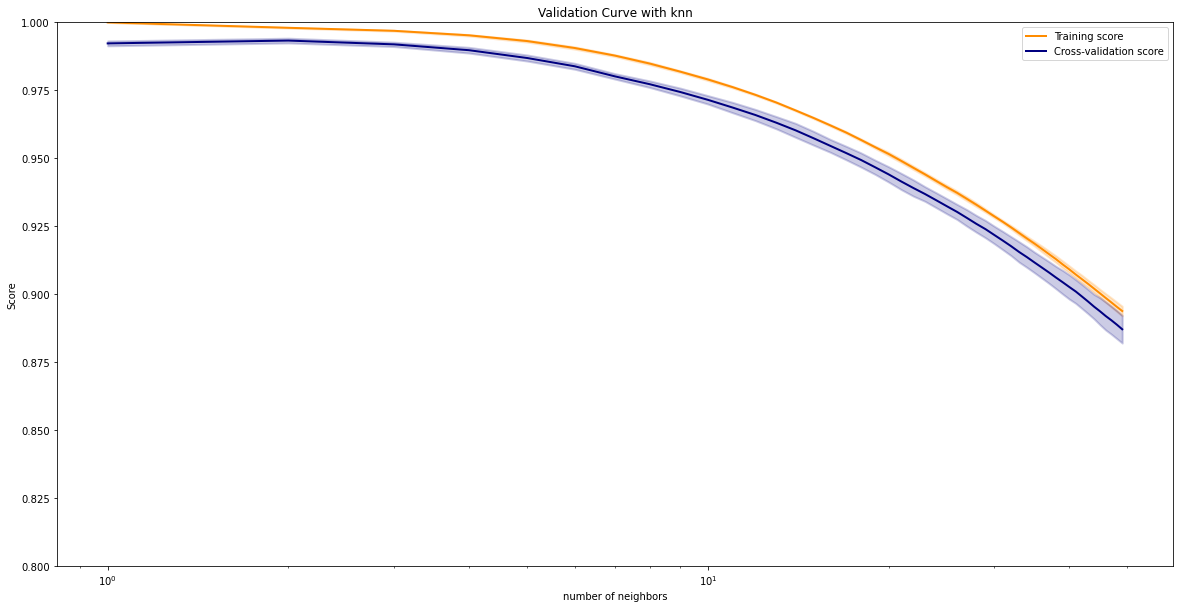

In [128]:
# A validation curve is used to evaluate an existing model based on hyper-parameters and is not used to tune a model. 
# This is because, if we tune the model according to the validation score, 
# the model may be biased towards the specific data against which the model is tuned; 
# thereby, not being a good estimate of the generalization of the model.

# source: https://www.geeksforgeeks.org/validation-curve/
# https://scikit-learn.org/stable/modules/learning_curve.html

import numpy as np
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt

n_estimators_range = [i for i in range(1,50)]

# validation_curve
train_scores, valid_scores = validation_curve(estimator=KNeighborsRegressor(), 
                                              X=X_train, y=y_train, 
                                              param_name="n_neighbors",
                                              param_range=n_estimators_range,
                                              cv=5)

# plotting the validation curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)


plt.figure(figsize=(20,10))
plt.title("Validation Curve with knn")
plt.xlabel(r"number of neighbors")
plt.ylabel("Score")
plt.ylim(0.8, 1.0)
lw = 2
plt.semilogx(n_estimators_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(n_estimators_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(n_estimators_range, valid_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(n_estimators_range, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [83]:
train=pd.DataFrame(list(train_scores_mean))
valid=pd.DataFrame(list(valid_scores_mean))
result=pd.concat([train,valid],axis=1)
result.columns=['train_score','test_score']
result['delta']=result['train_score']-result['test_score']